In [32]:
import os
from pathlib import Path
import sys
import warnings

import numpy as np
import pandas as pd
from mizani.formatters import percent_format
from plotnine import *
from scipy.stats import logistic
from scipy.stats import norm
from stargazer.stargazer import Stargazer
from patsy import dmatrices
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.discrete.discrete_model import Logit
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import log_loss

from statsmodels.iolib.summary2 import summary_col

warnings.filterwarnings("ignore")

In [33]:
import sys
# Add the directory containing py_helper_functions.py to the Python path
sys.path.append('C:/Users/zunai/Code/Data_Analysis_2/Gabors-Data-Analysis/da_case_studies/ch00-tech-prep')
from py_helper_functions import *


In [34]:
# Load the datasets
features_path = 'C:/Users/zunai/Code/Data_Analysis_2/Assignment2/hotels-europe_features.csv'
prices_path = 'C:/Users/zunai/Code/Data_Analysis_2/Assignment2/hotels-europe_price.csv'

features_df = pd.read_csv(features_path)
prices_df = pd.read_csv(prices_path)

# Display the first few rows of each dataframe to understand their structure
features_head = features_df.head()
prices_head = prices_df.head()

(features_head, prices_head)


(   hotel_id       city  distance  stars  rating      country city_actual  \
 0         1  Amsterdam       3.1    4.0     4.3  Netherlands   Amsterdam   
 1         2  Amsterdam       0.9    2.0     4.1  Netherlands   Amsterdam   
 2         3  Amsterdam       1.5    4.0     4.1  Netherlands   Amsterdam   
 3         4  Amsterdam       1.9    3.0     3.5  Netherlands   Amsterdam   
 4         5  Amsterdam       1.8    3.5     4.0  Netherlands   Amsterdam   
 
    rating_reviewcount center1label      center2label neighbourhood  ratingta  \
 0              1030.0  City centre  Montelbaanstoren     Amsterdam       4.0   
 1               372.0  City centre  Montelbaanstoren     Amsterdam       4.0   
 2               165.0  City centre  Montelbaanstoren     Amsterdam       4.0   
 3               298.0  City centre  Montelbaanstoren     Amsterdam       3.5   
 4                 4.0  City centre  Montelbaanstoren     Amsterdam       4.5   
 
    ratingta_count  distance_alter accommodation

In [35]:
# Filter for Amsterdam hotels in the features dataset
amsterdam_features_df = features_df[features_df['city'] == 'Amsterdam']

# Merge datasets on 'hotel_id'
merged_df = pd.merge(amsterdam_features_df, prices_df, on='hotel_id')

# Create the binary variable 'highly_rated'
merged_df['highly_rated'] = (merged_df['rating'] >= 4).astype(int)

# Display the first few rows of the merged dataframe
merged_head = merged_df.head()
merged_head


,hotel_id,city,distance,stars,rating,country,city_actual,rating_reviewcount,center1label,center2label,...,price,offer,offer_cat,year,month,weekend,holiday,nnights,scarce_room,highly_rated
0,1,Amsterdam,3.1,4.0,4.3,Netherlands,Amsterdam,1030.0,City centre,Montelbaanstoren,...,172,0,0% no offer,2017,11,1,0,1,0,1
1,1,Amsterdam,3.1,4.0,4.3,Netherlands,Amsterdam,1030.0,City centre,Montelbaanstoren,...,122,1,15-50% offer,2018,1,1,0,1,0,1
2,1,Amsterdam,3.1,4.0,4.3,Netherlands,Amsterdam,1030.0,City centre,Montelbaanstoren,...,122,1,15-50% offer,2017,12,0,1,1,0,1
3,1,Amsterdam,3.1,4.0,4.3,Netherlands,Amsterdam,1030.0,City centre,Montelbaanstoren,...,552,1,1-15% offer,2017,12,0,1,4,0,1
4,1,Amsterdam,3.1,4.0,4.3,Netherlands,Amsterdam,1030.0,City centre,Montelbaanstoren,...,122,1,15-50% offer,2018,2,1,0,1,0,1


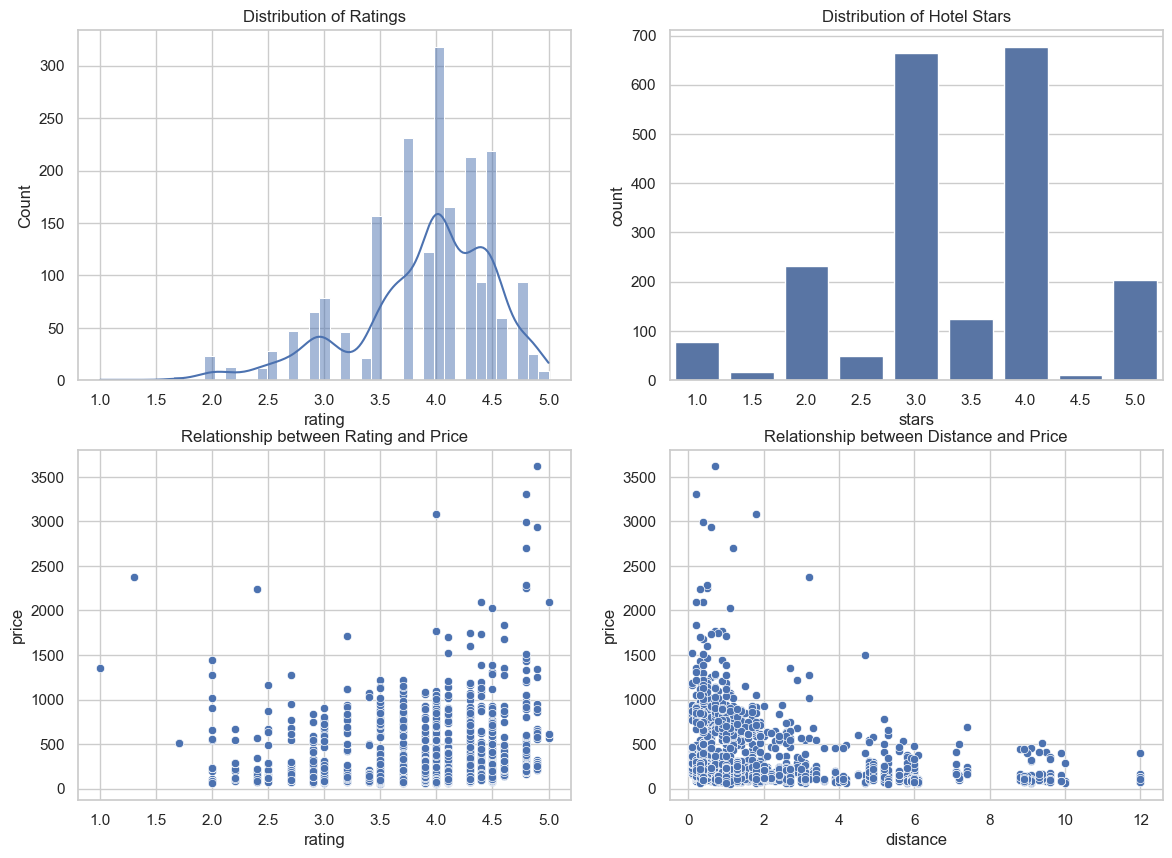

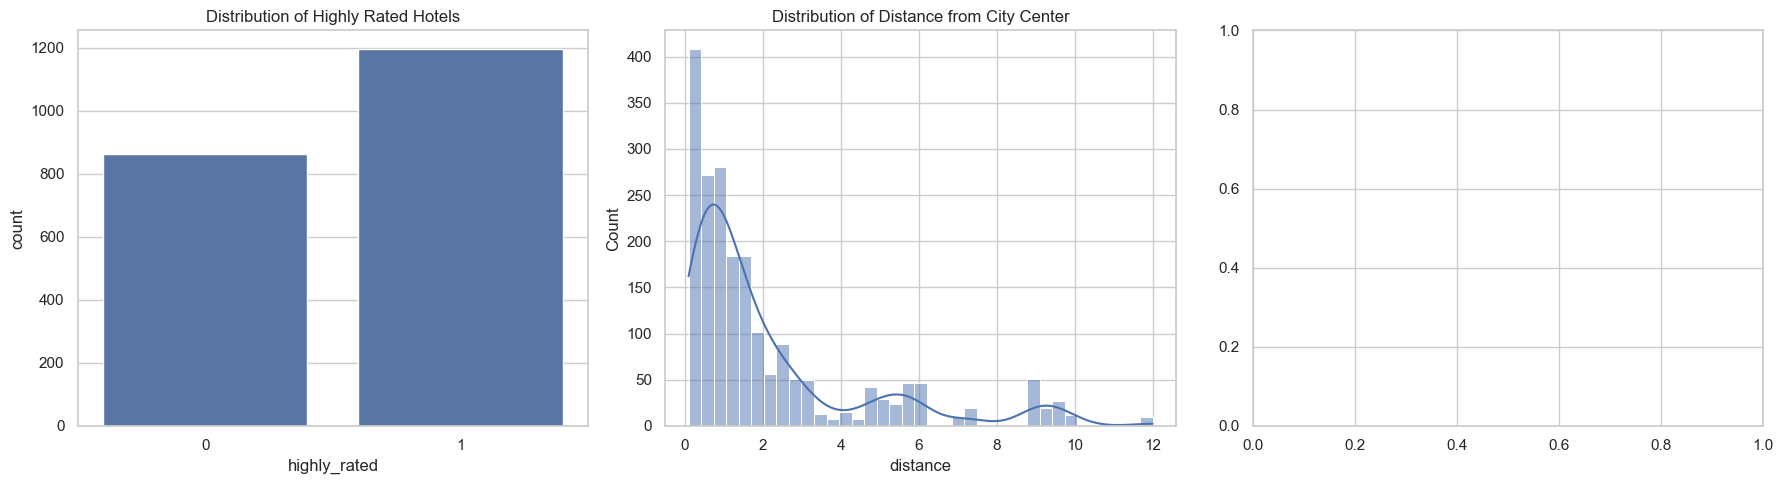

,distance,stars,rating,price,highly_rated
count,2058.000000,2058.000000,2045.000000,2058.00000,2058.000000
mean,2.151361,3.351555,3.904205,317.55102,0.581147
std,2.459368,0.957381,0.618582,335.16829,0.493491
min,0.100000,1.000000,1.000000,50.00000,0.000000
25%,0.500000,3.000000,3.700000,129.25000,0.000000
50%,1.100000,3.000000,4.000000,196.00000,1.000000
75%,2.600000,4.000000,4.300000,354.75000,1.000000
max,12.000000,5.000000,5.000000,3620.00000,1.000000


In [36]:
# Setting the aesthetic style of the plots
sns.set_style("whitegrid")

# Summary statistics for key features
summary_stats = merged_df[['distance', 'stars', 'rating', 'price', 'highly_rated']].describe()

# Plotting distributions and relationships
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Distribution of Ratings
sns.histplot(merged_df['rating'], kde=True, ax=axes[0, 0])
axes[0, 0].set_title('Distribution of Ratings')

# Distribution of Stars
sns.countplot(x='stars', data=merged_df, ax=axes[0, 1])
axes[0, 1].set_title('Distribution of Hotel Stars')

# Relationship between Rating and Price
sns.scatterplot(x='rating', y='price', data=merged_df, ax=axes[1, 0])
axes[1, 0].set_title('Relationship between Rating and Price')

# Relationship between Distance and Price
sns.scatterplot(x='distance', y='price', data=merged_df, ax=axes[1, 1])
axes[1, 1].set_title('Relationship between Distance and Price')

# Setting seaborn style for plots
sns.set(style="whitegrid")

# Exploratory Data Analysis (EDA)
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18, 5))

# Distribution of 'highly_rated'
sns.countplot(x='highly_rated', data=merged_df, ax=axes[0])
axes[0].set_title('Distribution of Highly Rated Hotels')

# Distribution of 'distance'
sns.histplot(merged_df['distance'], kde=True, ax=axes[1])
axes[1].set_title('Distribution of Distance from City Center')

plt.tight_layout()
plt.show()

summary_stats


In [37]:
# Checking for missing values
missing_values = merged_df.isnull().sum()

missing_values


hotel_id               0
city                   0
distance               0
stars                  0
rating                13
country                0
city_actual            0
rating_reviewcount    13
center1label           0
center2label           0
neighbourhood          0
ratingta              54
ratingta_count        54
distance_alter         0
accommodation_type     0
price                  0
offer                  0
offer_cat              0
year                   0
month                  0
weekend                0
holiday                0
nnights                0
scarce_room            0
highly_rated           0
dtype: int64

In [49]:
# Imputing missing values ('rating' and 'rating_reviewcount' are columns with missing values)
merged_df['rating'] = merged_df['rating'].fillna(merged_df['rating'].median())
merged_df['rating_reviewcount'] = merged_df['rating_reviewcount'].fillna(merged_df['rating_reviewcount'].median())

# Handling outliers in price ('price' is the column with potential outliers)
price_threshold = merged_df['price'].quantile(0.99)
merged_df = merged_df[merged_df['price'] <= price_threshold]

# Regression analysis
# OLS regression model
lpm_model = smf.ols('highly_rated ~ distance + stars', data=merged_df).fit(cov_type='HC1')

# Logit regression model
logit_model = smf.logit('highly_rated ~ distance + stars', data=merged_df).fit()

# Probit regression model
probit_model = smf.probit('highly_rated ~ distance + stars', data=merged_df).fit()

# Creating Stargazer objects for regression tables
stargazer = Stargazer([lpm, logit_model, probit_model])
stargazer.covariate_order(['distance', 'stars', 'Intercept'])
stargazer.rename_covariates({'Intercept': 'Constant'})

# Displaying regression tables
stargazer


Optimization terminated successfully.
         Current function value: 0.479979
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.480777
         Iterations 6


### Model (1) - Linear Probability Model: 
The coefficients represent the change in probability of a hotel being highly rated for a one-unit change in the predictor. For example, if the coefficient for distance is negative, it means that for each additional unit increase in distance from a certain point (like the city center), the probability of the hotel being highly rated decreases.
#### distance: 
The coefficient is 0.029 and is statistically significant at the 1% level (p < 0.01). This means that for each additional unit increase in distance (presumably kilometers or miles), the probability of a hotel being highly rated increases by 2.9 percentage points. This is counterintuitive because we would generally expect the probability of being highly rated to decrease with an increase in distance from a central location.#### stars:
 The coefficient is 0.284 and is also statistically significant at the 1% level. This indicates that for each additional star, the probability of a hotel being highly rated increases by 28.4 percentage points.

### Model (2) - Logit Model:
#### distance: 
The coefficient is 0.159 and significant at the 1% level. This log-odds coefficient means that for each unit increase in distance, the log-odds of a hotel being highly rated increase by 0.159. The interpretation of log-odds coefficients is less intuitive, but the positive sign still indicates an increasing trend of being highly rated with distance.
#### stars: 
The coefficient is 1.722 and significant at the 1% level. For each additional star, the log-odds of being highly rated increase by 1.722.

### Model (3) - Probit Model:

#### distance: 
The coefficient is 0.086 and significant at the 1% level. The probit model's coefficients are in terms of the standard normal cumulative distribution. A positive coefficient again implies that higher distance is associated with an increased probability of being highly rated, holding other factors constant.
#### stars: 
The coefficient is 1.002 and significant at the 1% level, meaning that more stars are associated with a higher probability of being highly rated.

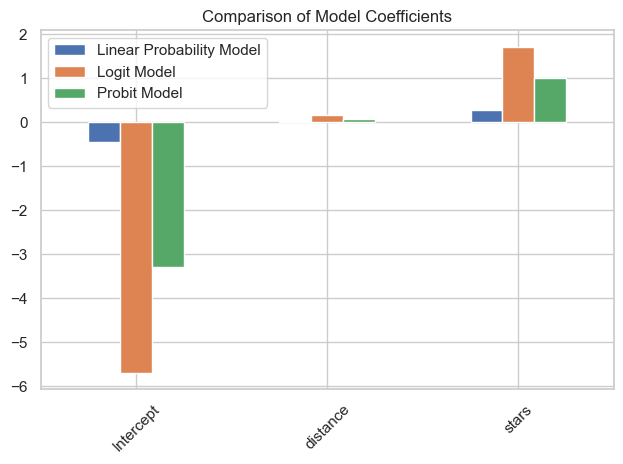

In [45]:
# Comparing the coefficients visually
# Creating a dataframe for coefficients
coefficients = pd.DataFrame({
    'Linear Probability Model': lpm_model.params,
    'Logit Model': logit_model.params,
    'Probit Model': probit_model.params
})

# Plotting coefficients
coefficients.plot(kind='bar')
plt.title('Comparison of Model Coefficients')
plt.xticks(rotation=45)  
plt.tight_layout()  
plt.show()


The graph above provides a visual comparison of how each predictor's effect size differs across the three models.
#### Intercept:

All three models have negative intercepts, which suggests that the baseline probability (LPM) or log-odds (Logit and Probit) of a hotel being highly rated when distance and stars are at their reference level (usually zero) is below the average. The intercept is most negative in the Logit Model, followed by the Probit Model, and least negative in the LPM.
#### Distance:

The coefficient for distance is positive in all three models, indicating that as the distance increases, the likelihood or probability of a hotel being highly rated also increases. This is somewhat counterintuitive, as one might expect hotels closer to a central location to have a higher probability of being highly rated. The LPM shows a smaller effect size compared to the Logit and Probit models.
#### Stars:

The coefficient for stars is positive and has the largest magnitude across all models, suggesting that an increase in the number of stars significantly increases the likelihood or probability of a hotel being highly rated. The magnitude of the coefficient is highest in the Logit Model, followed by the Probit Model, and is smallest in the LPM.

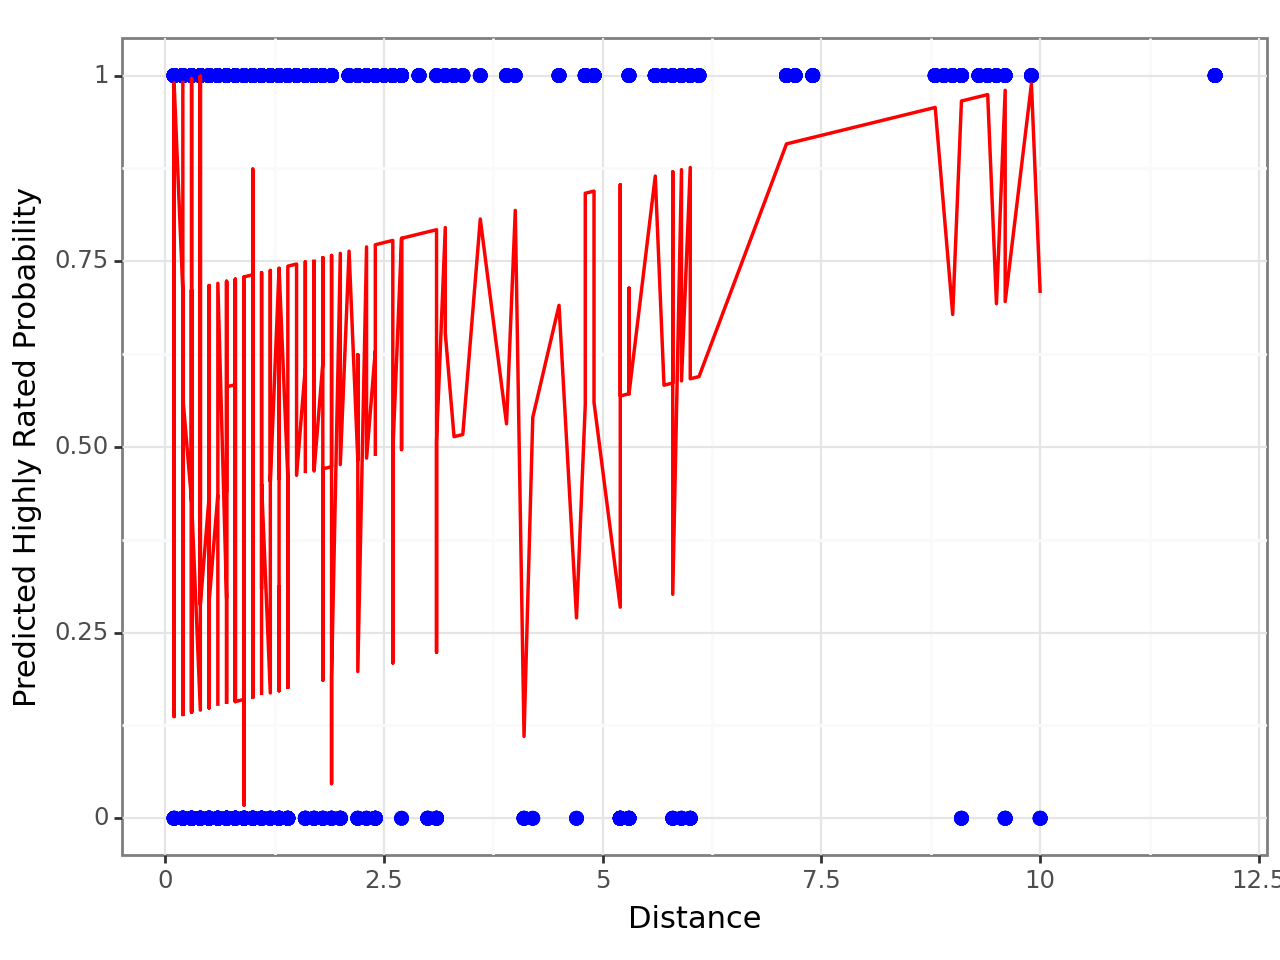

In [47]:
# Predicting values for plotting
merged_df['pred_ols'] = lpm_model.predict()
merged_df['pred_logit'] = logit_model.predict()
merged_df['pred_probit'] = probit_model.predict()

# Plotting OLS predictions
plot_ols = (ggplot(merged_df, aes('distance', 'pred_ols')) +
            geom_point(aes('distance', 'highly_rated'), size=2, color='blue') +
            geom_line(aes('distance', 'pred_ols'), color='red', size=0.7) +
            labs(x='Distance', y='Predicted Highly Rated Probability') +
            coord_cartesian(xlim=(merged_df['distance'].min(), merged_df['distance'].max()), ylim=(0, 1)) +
            scale_y_continuous(limits=(0, 1)) +
            scale_x_continuous(limits=(merged_df['distance'].min(), merged_df['distance'].max())) +
            theme_bw()
           )

# Displaying plots
print(plot_ols)

In [48]:
# Calculating marginal effects for the Logit model
logit_marginal_effects = logit_model.get_margeff()
print(logit_marginal_effects.summary())

# Calculating marginal effects for the Probit model
probit_marginal_effects = probit_model.get_margeff()
print(probit_marginal_effects.summary())

# Calculating predicted probabilities for the Logit model
merged_df['pred_prob_logit'] = logit_model.predict()

# Calculating predicted probabilities for the Probit model
merged_df['pred_prob_probit'] = probit_model.predict()

# The predicted probabilities can then be used to analyze or visualize the model's predictions.


        Logit Marginal Effects       
Dep. Variable:           highly_rated
Method:                          dydx
At:                           overall
                dy/dx    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
distance       0.0250      0.004      6.390      0.000       0.017       0.033
stars          0.2709      0.007     36.691      0.000       0.256       0.285
       Probit Marginal Effects       
Dep. Variable:           highly_rated
Method:                          dydx
At:                           overall
                dy/dx    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
distance       0.0232      0.004      6.214      0.000       0.016       0.031
stars          0.2714      0.007     38.645      0.000       0.258       0.285


In [31]:
!conda list scikit-learn

# packages in environment at C:\Users\zunai\anaconda3\envs\mycondaenv:
#
# Name                    Version                   Build  Channel
scikit-learn              1.3.0           py311hf62ec03_0  
